In [2]:
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.model_selection
import sktime.datatypes
from sklearn.linear_model import RidgeClassifierCV
from sklearn.pipeline import make_pipeline

from sktime.datasets import load_arrow_head  # univariate dataset
from sktime.datasets import load_basic_motions  # multivariate dataset
from sktime.transformations.panel.rocket import Rocket
from sktime.forecasting.model_selection import temporal_train_test_split
from sklearn import preprocessing

# What I want to do
- Find the distribution of number of tweets per day (activity) of each individual from the sample cohort
- undersample sample cohort to match sample size from depressed cohort

In [3]:
#depression tweets
dt = pd.read_csv("data/depression_tweets.tsv", sep="\t", index_col="tweet_id", parse_dates=[2])
#dt["created_at"] = pd.to_datetime(dt["created_at"])
n_depression = len(dt['user_id'].unique())
print(n_depression)

#sample tweets
st = pd.read_csv("data/sample_tweets.tsv", sep="\t", index_col="tweet_id", parse_dates=[2])
#st["created_at"] = pd.to_datetime(st["created_at"])


603


In [4]:
st.set_index('created_at', inplace=True)

In [5]:
avgs = st.groupby(st.index.date).count()

In [12]:
len(st.groupby(st.index.date).nunique())

3735

get the avg daily activity of each user

In [6]:
average_pairs = {}
averages = []
for user in st.user_id.unique():
    tmp = st[st['user_id'] == user]
    tweets_per_day = tmp.groupby(tmp.index.date).count()
    n_days = len(tweets_per_day.index.unique())
    average_pairs.update({''+user+'': ''+str(round(tweets_per_day.user_id.sum(axis=0)/n_days))+''})
    averages.append(round(tweets_per_day.user_id.sum(axis=0)/n_days))

<function matplotlib.pyplot.show(close=None, block=None)>

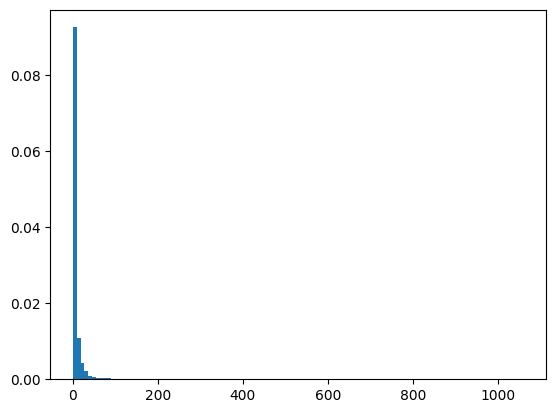

In [97]:
import matplotlib.pyplot as plt

plt.hist(averages, density=True, bins=120)
plt.show

In [98]:
df_averages = pd.DataFrame(dict([(key, pd.Series(value)) for key, value in average_pairs.items()])).transpose()

In [99]:
average_dist = {}
for avg in df_averages[0].unique():
    tmp_dist = float((df_averages[df_averages[0]==avg].count()/len(df_averages)).iloc[0]) # because otherwise could cause type error in the future
    average_dist.update({str(avg): str(tmp_dist)})

In [100]:
dist_df = pd.DataFrame(average_dist.items(), columns=['tweets per day', 'percentage'])
dist_df = dist_df.astype({'tweets per day': 'int32'})
dist_df = dist_df.astype({'percentage': 'float'})
dist_df = dist_df.sort_values(by=['tweets per day'])
dist_df

,tweets per day,percentage
3,1,0.229011
0,2,0.212546
1,3,0.123146
4,4,0.082052
11,5,0.051027
...,...,...
36,348,0.000136
118,356,0.000136
110,624,0.000136
115,892,0.000136


In [7]:
pairs_df = pd.DataFrame(average_pairs.items(), columns=['user id', 'tweets per day'])
pairs_df = pairs_df.astype({'tweets per day': 'int32'})
pairs_df = pairs_df.sort_values(by=['tweets per day'])
pairs_df

,user id,tweets per day
1330,uR1330,1
5065,uR5065,1
1259,uR1259,1
5069,uR5069,1
3405,uR3405,1
...,...,...
259,uR0259,348
7207,uR7207,356
5920,uR5920,624
6361,uR6361,892


In [8]:
pairs_df.to_csv('pairs_tpd_users.csv')

In [103]:
samples = pd.DataFrame(columns=['user id', 'tweets per day'])
for tpd in pairs_df['tweets per day'].unique():
    tmp_df = pairs_df[pairs_df['tweets per day']==tpd]
    frac = float(dist_df.loc[dist_df['tweets per day']==tpd]['percentage'].iloc[0])
    sampled_tmp_df = tmp_df.sample(n=int(n_depression*frac), random_state=42) # use n=int(n_depression*frac) to get the same number as users as in the depressed cohort with distribution of overall rnd sample cohort
    samples = samples._append(sampled_tmp_df, ignore_index=True)
samples

,user id,tweets per day
0,uR5971,1
1,uR1442,1
2,uR6316,1
3,uR5041,1
4,uR4991,1
...,...,...
561,uR7312,31
562,uR1161,32
563,uR3451,33
564,uR1549,33


### Fill remaining number of needed samples with 1 entity of each not yet present class starting with highest percentage of occurrence

In [110]:
#for tpd in samples['tweets per day'].unique():
#    print(samples[samples['tweets per day']==tpd].count())

In [113]:
present_tpd = samples['tweets per day'].unique().tolist()
all_tpd = dist_df['tweets per day'].unique().tolist()
diff_tpd = list(set(present_tpd).symmetric_difference(set(all_tpd)))
dist_df = dist_df.sort_values('percentage', ascending=False)
dist_df

,tweets per day,percentage
3,1,0.229011
0,2,0.212546
1,3,0.123146
4,4,0.082052
11,5,0.051027
...,...,...
58,121,0.000136
116,253,0.000136
76,311,0.000136
110,624,0.000136


In [114]:
needed_tpd = []
counter = n_depression-len(samples['user id'].unique())
for tpd in dist_df['tweets per day'].unique():
    if tpd in diff_tpd and counter > 0:
        counter = counter - 1
        tmp_df = pairs_df[pairs_df['tweets per day']==tpd]
        sampled_tmp_df = tmp_df.sample(n=1, random_state=42)
        samples = samples._append(sampled_tmp_df, ignore_index=True)
samples

,user id,tweets per day
0,uR5971,1
1,uR1442,1
2,uR6316,1
3,uR5041,1
4,uR4991,1
...,...,...
598,uR2621,67
599,uR3759,72
600,uR5979,60
601,uR4627,90


In [115]:
samples.to_csv('sampled_ids')

In [129]:
#df with columns user 0-n with timestamps as row values for each user column
#depression tweets
dt = pd.read_csv("data/depression_tweets.tsv", sep="\t", index_col="tweet_id")
dt["created_at"] = pd.to_datetime(dt["created_at"])

#sample tweets
st = pd.read_csv("data/sample_tweets.tsv", sep="\t", index_col="tweet_id")
st["created_at"] = pd.to_datetime(st["created_at"])

samples = pd.read_csv('sampled_ids')

data = {}
labels = []
for user in dt.user_id.unique():
    tmp = dt[dt['user_id'] == user]
    tweet_list = tmp['created_at'].map(lambda datetime: int(round(datetime.timestamp()))).to_numpy()
    data.update({''+user+'': tweet_list})
    labels.append(1)

for user in samples['user id'].unique():
    tmp = st[st['user_id'] == user]
    tweet_list = tmp['created_at'].map(lambda datetime: int(round(datetime.timestamp()))).to_numpy()
    data.update({''+user+'': tweet_list})
    labels.append(0)

df_data = pd.DataFrame(dict([(key, pd.Series(value)) for key, value in data.items()]))
df_labels = pd.DataFrame(labels)
df_data.to_csv('new_sampled_data_int_trans.csv')
df_labels.to_csv('new_sampled_data_int_trans_labels.csv')

In [156]:
data = pd.read_csv('new_sampled_data_int_trans.csv')
labels = pd.read_csv('new_sampled_data_int_trans_labels.csv')
data = data.transpose()
data = data.drop(['Unnamed: 0'])
labels = labels.drop(columns=['Unnamed: 0'])
data.index = range(0, len(data.index))
data.sort_index()
data = data.fillna(0)
y_train, y_test, X_train, X_test = temporal_train_test_split(labels,data, test_size=0.2)
print(X_train.shape)
print(X_test.shape)

(964, 3222)
(242, 3222)


In [157]:
rocket = Rocket()
rocket.fit(X_train)
print(X_train.shape)
X_train_transform = rocket.transform(X_train)
print(X_train_transform.shape)
classifier = RidgeClassifierCV(alphas=np.logspace(-3,3,10))
classifier.fit(X_train, y_train)

(964, 3222)
(1, 20000)


C:\Users\99mor\PycharmProjects\phaseUnlocking\venv\lib\site-packages\sklearn\linear_model\_ridge.py:1182: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RidgeClassifierCV(alphas=array([1.00000000e-03, 4.64158883e-03, 2.15443469e-02, 1.00000000e-01,
       4.64158883e-01, 2.15443469e+00, 1.00000000e+01, 4.64158883e+01,
       2.15443469e+02, 1.00000000e+03]))

In [158]:
print(X_test.shape)
X_test_transform = rocket.transform(X_test)
print(X_test_transform.shape)
X_test = X_test.replace(-float('inf'), -sys.float_info.min)
print(X_test.shape)
classifier.score(X_test, y_test)

(242, 3222)
(1, 20000)
(242, 3222)


0.49173553719008267